## Expectation Maximization (EM)

In [172]:
import numpy as np
import time as T
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.utils.extmath import cartesian
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

In [8]:
class MHP:
    def __init__(self, alpha=[[0.5]], mu=[0.1], omega=1.0):
        '''
        params should be of form
        alpha: numpy.array((u,u)), mu: numpy.array((,u)), omega: float
        '''
        
        self.data = []
        self.alpha, self.mu, self.omega = np.array(alpha), np.array(mu), omega
        self.dim = self.mu.shape[0]
        self.check_stability()

    def check_stability(self):
        '''
        check stability of process (max alpha eigenvalue < 1)
        '''
        w,v = np.linalg.eig(self.alpha)
        me = np.amax(np.abs(w))
        print('Max eigenvalue: %1.5f' % me)
        if me >= 1.:
            print('(WARNING) Unstable.')

### Generating simulated data

In [9]:
class MHP(MHP): # for Jupyter notebook
    
    def generate_seq(self, horizon):
        '''
        Generate a sequence based on mu, alpha, omega values. 
        Uses Ogata's thinning method, with some speedups, noted below
        '''

        self.data = []  # clear history

        Istar = np.sum(self.mu)
        s = np.random.exponential(scale=1./Istar)

        # attribute (weighted random sample, since sum(mu)==Istar)
        n0 = np.random.choice(np.arange(self.dim), 
                              1, 
                              p=(self.mu / Istar))
        self.data.append([s, n0])

        # value of \lambda(t_k) where k is most recent event
        # starts with just the base rate
        lastrates = self.mu.copy()

        decIstar = False
        while True:
            tj, uj = self.data[-1][0], int(self.data[-1][1])

            if decIstar:
                # if last event was rejected, decrease Istar
                Istar = np.sum(rates)
                decIstar = False
            else:
                # otherwise, we just had an event, so recalc Istar (inclusive of last event)
                Istar = np.sum(lastrates) + \
                        self.omega * np.sum(self.alpha[:,uj])

            # generate new event
            s += np.random.exponential(scale=1./Istar)

            # calc rates at time s (use trick to take advantage of rates at last event)
            rates = self.mu + np.exp(-self.omega * (s - tj)) * \
                    (self.alpha[:,uj].flatten() * self.omega + lastrates - self.mu)

            # attribution/rejection test
            # handle attribution and thinning in one step as weighted random sample
            diff = Istar - np.sum(rates)
            try:
                n0 = np.random.choice(np.arange(self.dim+1), 1, 
                                      p=(np.append(rates, diff) / Istar))
            except ValueError:
                # by construction this should not happen
                print('Probabilities do not sum to one.')
                self.data = np.array(self.data)
                return self.data

            if n0 < self.dim:
                self.data.append([s, n0])
                # update lastrates
                lastrates = rates.copy()
            else:
                decIstar = True

            # if past horizon, done
            if s >= horizon:
                self.data = np.array(self.data)
                self.data = self.data[self.data[:,0] < horizon]
                return self.data

### EM learning

In [10]:
class MHP(MHP): # for Jupyter notebook
    
    def EM(self, Ahat, mhat, omega, seq=[], smx=None, tmx=None, regularize=False, 
           Tm=-1, maxiter=100, epsilon=0.01, verbose=True):
        '''
        Implements MAP EM. Optional to regularize with `smx` and `tmx` matrix (shape=(dim,dim)).
        In general, the `tmx` matrix is a pseudocount of parent events from column j,
        and the `smx` matrix is a pseudocount of child events from column j -> i
        '''
        
        # if no sequence passed, uses class instance data
        if len(seq) == 0:
            seq = self.data

        N = len(seq)
        dim = mhat.shape[0]
        Tm = float(seq[-1,0]) if Tm < 0 else float(Tm)
        sequ = seq[:,1].astype(int)

        p_ii = np.random.uniform(0.01, 0.99, size=N)
        p_ij = np.random.uniform(0.01, 0.99, size=(N, N))

        # PRECOMPUTATIONS

        # diffs[i,j] = t_i - t_j for j < i (o.w. zero)
        diffs = pairwise_distances(np.array([seq[:,0]]).T, metric = 'euclidean')
        diffs[np.triu_indices(N)] = 0

        # kern[i,j] = omega*np.exp(-omega*diffs[i,j])
        kern = omega*np.exp(-omega*diffs)

        colidx = np.tile(sequ.reshape((1,N)), (N,1))
        rowidx = np.tile(sequ.reshape((N,1)), (1,N))

        # approx of Gt sum in a_{uu'} denom
        seqcnts = np.array([len(np.where(sequ==i)[0]) for i in range(dim)])
        seqcnts = np.tile(seqcnts, (dim,1))

        # returns sum of all pmat vals where u_i=a, u_j=b
        # *IF* pmat upper tri set to zero, this is 
        # \sum_{u_i=u}\sum_{u_j=u', j<i} p_{ij}
        def sum_pij(a,b):
            c = cartesian([np.where(seq[:,1]==int(a))[0], np.where(seq[:,1]==int(b))[0]])
            return np.sum(p_ij[c[:,0], c[:,1]])
        vp = np.vectorize(sum_pij)

        # \int_0^t g(t') dt' with g(t)=we^{-wt}
        # def G(t): return 1 - np.exp(-omega * t)
        #   vg = np.vectorize(G)
        # Gdenom = np.array([np.sum(vg(diffs[-1,np.where(seq[:,1]==i)])) for i in range(dim)])

        k = 0
        old_LL = -10000
        START = T.time()
        while k < maxiter:
            Auu = Ahat[rowidx, colidx]
            ag = np.multiply(Auu, kern)
            ag[np.triu_indices(N)] = 0

            # compute m_{u_i}
            mu = mhat[sequ]

            # compute total rates of u_i at time i
            rates = mu + np.sum(ag, axis=1)

            # compute matrix of p_ii and p_ij  (keep separate for later computations)
            p_ij = np.divide(ag, np.tile(np.array([rates]).T, (1,N)))
            p_ii = np.divide(mu, rates)

            # compute mhat:  mhat_u = (\sum_{u_i=u} p_ii) / T
            mhat = np.array([np.sum(p_ii[np.where(seq[:,1]==i)]) \
                             for i in range(dim)]) / Tm

            # ahat_{u,u'} = (\sum_{u_i=u}\sum_{u_j=u', j<i} p_ij) / \sum_{u_j=u'} G(T-t_j)
            # approximate with G(T-T_j) = 1
            if regularize:
                Ahat = np.divide(np.fromfunction(lambda i,j: vp(i,j), (dim,dim)) + (smx-1),
                                 seqcnts + tmx)
            else:
                Ahat = np.divide(np.fromfunction(lambda i,j: vp(i,j), (dim,dim)),
                                 seqcnts)

            if k % 10 == 0:
                try:
                    term1 = np.sum(np.log(rates))
                except:
                    print('Log error!')
                term2 = Tm * np.sum(mhat)
                term3 = np.sum(np.sum(Ahat[u,int(seq[j,1])] for j in range(N)) for u in range(dim))
                #new_LL = (1./N) * (term1 - term2 - term3)
                new_LL = (1./N) * (term1 - term3)
                if abs(new_LL - old_LL) <= epsilon:
                    if verbose:
                        print('Reached stopping criterion. (Old: %1.3f New: %1.3f)' % (old_LL, new_LL))
                    return Ahat, mhat
                if verbose:
                    print('After ITER %d (old: %1.3f new: %1.3f)' % (k, old_LL, new_LL))
                    print(' terms %1.4f, %1.4f, %1.4f' % (term1, term2, term3))

                old_LL = new_LL

            k += 1

        if verbose:
            print('Reached max iter (%d).' % maxiter)

        self.Ahat = Ahat
        self.mhat = mhat
        return Ahat, mhat

### Visualization

In [11]:
class MHP(MHP): # for Jupyter notebook
    
    def get_rate(self, ct, d):
        # return rate at time ct in dimension d
        seq = np.array(self.data)
        if not np.all(ct > seq[:,0]): seq = seq[seq[:,0] < ct]
        return self.mu[d] + \
            np.sum([self.alpha[d,int(j)]*self.omega*np.exp(-self.omega*(ct-t)) for t,j in seq])

In [12]:
class MHP(MHP): # for Jupyter notebook
    
    def plot_rates(self, horizon=-1):

        if horizon < 0:
            horizon = np.amax(self.data[:,0])

        f, axarr = plt.subplots(self.dim*2,1, sharex='col', 
                                gridspec_kw = {'height_ratios':sum([[3,1] for i in range(self.dim)],[])}, 
                                figsize=(8,self.dim*2))
        xs = np.linspace(0, horizon, (horizon/100.)*1000)
        for i in range(self.dim):
            row = i * 2

            # plot rate
            r = [self.get_rate(ct, i) for ct in xs]
            axarr[row].plot(xs, r, 'k-')
            axarr[row].set_ylim([-0.01, np.amax(r)+(np.amax(r)/2.)])
            axarr[row].set_ylabel('$\lambda(t)_{%d}$' % i, fontsize=14)
            r = []

            # plot events
            subseq = self.data[self.data[:,1]==i][:,0]
            axarr[row+1].plot(subseq, np.zeros(len(subseq)) - 0.5, 'bo', alpha=0.2)
            axarr[row+1].yaxis.set_visible(False)

            axarr[row+1].set_xlim([0, horizon])

        plt.tight_layout()

In [13]:
class MHP(MHP): # for Jupyter notebook
    
    def plot_events(self, horizon=-1, showDays=True, labeled=True):
        if horizon < 0:
            horizon = np.amax(self.data[:,0])

        fig = plt.figure(figsize=(10,2))
        ax = plt.gca()
        for i in range(self.dim):
            subseq = self.data[self.data[:,1]==i][:,0]
            plt.plot(subseq, np.zeros(len(subseq)) - i, 'bo', alpha=0.2)

        if showDays:
            for j in range(1,int(horizon)):
                plt.plot([j,j], [-self.dim, 1], 'k:', alpha=0.15)

        if labeled:
            ax.set_yticklabels('')
            ax.set_yticks(-np.arange(0, self.dim), minor=True)
            ax.set_yticklabels([r'$e_{%d}$' % i for i in range(self.dim)], minor=True)
        else:
            ax.yaxis.set_visible(False)

        ax.set_xlim([0,horizon])
        ax.set_ylim([-self.dim, 1])
        ax.set_xlabel('Days')
        plt.tight_layout()

### Experimentation

In [25]:
P = MHP()
seq = P.generate_seq(60)

print(seq)
print(type(seq))
print(seq.shape)

print(type(seq[0][1]))

Max eigenvalue: 0.50000
[[ 3.47363103  0.        ]
 [ 4.77188125  0.        ]
 [ 5.77165139  0.        ]
 [ 6.65294338  0.        ]
 [ 7.43264572  0.        ]
 [13.38444895  0.        ]
 [36.26946748  0.        ]
 [36.37884636  0.        ]
 [38.12176838  0.        ]
 [45.00902515  0.        ]]
<class 'numpy.ndarray'>
(10, 2)
<class 'numpy.float64'>


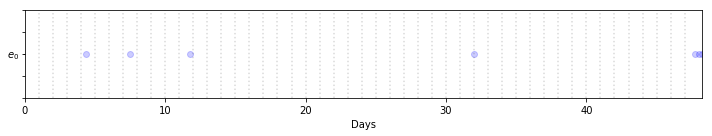

In [15]:
P.plot_events()

Max eigenvalue: 0.10000


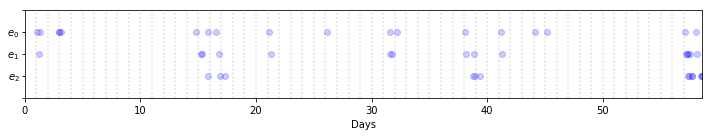

In [16]:
m = np.array([0.2, 0.0, 0.0])
a = np.array([[0.1, 0.0, 0.0], 
              [0.9, 0.0, 0.0],
              [0.0, 0.9, 0.0]])
w = 3.1

P = MHP(mu=m, alpha=a, omega=w)
P.generate_seq(60)
P.plot_events()

/opt/miniconda3/envs/sugar/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


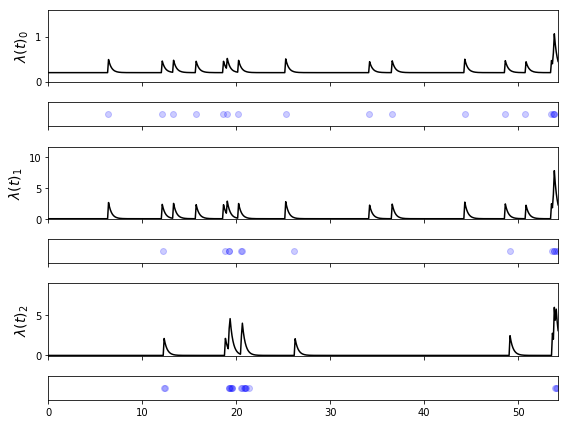

In [13]:
P.plot_rates()

In [17]:
mhat = np.random.uniform(0,1, size=3)
ahat = np.random.uniform(0,1, size=(3,3))
w = 3.

print(ahat)
print(mhat)

P.EM(ahat, mhat, w)

[[0.75287618 0.06961372 0.45038138]
 [0.77744035 0.92297796 0.05151437]
 [0.44957291 0.67244717 0.99996068]]
[0.65141776 0.42090456 0.28800789]
After ITER 0 (old: -10000.000 new: 0.020)
 terms 28.7473, 18.1688, 27.8312
After ITER 10 (old: 0.020 new: -0.912)
 terms -11.5746, 15.6289, 30.3711
Reached stopping criterion. (Old: -0.912 New: -0.914)


(array([[8.77820309e-02, 6.26445852e-02, 2.38423300e-05],
        [7.56812083e-01, 8.44428113e-02, 8.51848692e-03],
        [1.28190540e-07, 7.42972249e-01, 1.42724151e-01]]),
 array([2.64272200e-01, 7.56635564e-14, 1.87063452e-16]))

### Running on real data

In [3]:
events_d_one = pd.read_csv('event_times_ond_d_1314_ds0_one.csv')
events_d_all = pd.read_csv('event_times_ond_d_1314_ds0_all.csv')
events_hr_one = pd.read_csv('event_times_ond_hr_1314_ds0_one.csv')
events_hr_all = pd.read_csv('event_times_ond_hr_1314_ds0_all.csv')

events_d_one.head()

,time,unit
0,224.0,E08
1,8.0,E04
2,349.0,E09
3,100.0,B07
4,169.0,P20


In [56]:
# MULTIVARIATE results for all dataframes

df_list = [events_d_one, events_d_all, events_hr_one, events_hr_all]

def run_multivariate_EM(df):
    num_units = df['unit'].nunique()
    df_augmented = df
    df_augmented['unit_num'] = pd.Categorical(df.unit).codes
    data = df_augmented[['time','unit_num']].values
    # Running EM
    A_init = np.random.uniform(0, 1, size=(num_units, num_units))
    mu_init = np.random.uniform(0, 1, size=num_units)
    w = 1.
    P = MHP(alpha=A_init, mu=mu_init, omega=w)
    A_learned, mu_learned = P.EM(A_init, mu_init, w, data)
    return A_learned, mu_learned

A_learned_list, mu_learned_list = [], []
for df in df_list:
    A_learned, mu_learned = run_multivariate_EM(df)
    A_learned_list.append(A_learned)
    mu_learned_list.append(mu_learned)
    print('----------------------------')

print('All A matrices:', A_learned_list) # count: 4
print('All mu vectors:', mu_learned_list) # count: 4

Max eigenvalue: 20.23789
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.571)
 terms 72.0871, 388.1886, 683.8114
After ITER 10 (old: -0.571 new: -3.040)
 terms -2662.9446, 476.1440, 595.8560
Reached stopping criterion. (Old: -3.040 New: -3.036)
----------------------------
Max eigenvalue: 20.68410
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.365)
 terms 391.3900, 442.4323, 870.5677
After ITER 10 (old: -0.365 new: -2.728)
 terms -2804.0152, 535.7467, 777.2533
Reached stopping criterion. (Old: -2.728 New: -2.724)
----------------------------
Max eigenvalue: 20.71364
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -0.878)
 terms -867.4306, 998.2280, 73.7720
After ITER 10 (old: -0.878 new: -5.892)
 terms -6163.5346, 918.9679, 153.0321
Reached stopping criterion. (Old: -5.892 New: -5.893)
----------------------------
Max eigenvalue: 20.35703
(WARNING) Unstable.
After ITER 0 (old: -10000.000 new: -1.156)
 terms -1275.4924, 1070.6003, 242.3997
After ITER 10 (old:

In [87]:
# UNIVARIATE results for all dataframes

def run_univariate_EM(df):
    alpha_init = np.random.uniform(0, 1, size=(1, 1))
    mu_init = np.random.uniform(0, 1, size=1)
    w = 1.
    
    num_units = df['unit'].nunique()
    df_augmented = df
    df_augmented['unit_num'] = pd.Categorical(df.unit).codes
    
    alpha_learned_list, mu_learned_list = [], []
    for i in range(num_units):
        df_i = df_augmented[df_augmented['unit_num'] == i]
        df_i['unit_num'] = 0
        data_i = df_i[['time','unit_num']].values
        #print(data_i)
    
        # Running EM
        P = MHP(alpha=alpha_init, mu=mu_init, omega=w)
        alpha_learned_i, mu_learned_i = P.EM(alpha_init, mu_init, w, data_i)
        alpha_learned_list.append(alpha_learned_i)
        mu_learned_list.append(mu_learned_i)
        
        flattened_alpha_learned_list = [item[0][0] for item in alpha_learned_list]
        flattened_mu_learned_list = [item[0] for item in mu_learned_list]
    
    return flattened_alpha_learned_list, flattened_mu_learned_list

In [88]:
# Trial on single dataframe

alpha_learned_list, mu_learned_list = run_univariate_EM(events_d_one)
print(alpha_learned_list)
print("-------------------")
print(mu_learned_list)

/opt/miniconda3/envs/sugar/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Max eigenvalue: 0.70351
After ITER 0 (old: -10000.000 new: -0.537)
 terms -14.8200, 28.2539, 0.7461
After ITER 10 (old: -0.537 new: -2.764)
 terms -80.1543, 28.9997, 0.0003
Reached stopping criterion. (Old: -2.764 New: -2.764)
Max eigenvalue: 0.70351
After ITER 0 (old: -10000.000 new: -0.523)
 terms -23.7377, 48.5264, 3.4736
After ITER 10 (old: -0.523 new: -2.226)
 terms -115.5139, 51.7359, 0.2641
Reached stopping criterion. (Old: -2.226 New: -2.222)
Max eigenvalue: 0.70351
After ITER 0 (old: -10000.000 new: -0.480)
 terms -1.3696, 3.4506, 0.5494
After ITER 10 (old: -0.480 new: -4.104)
 terms -15.4030, 2.9858, 1.0142
Reached stopping criterion. (Old: -4.104 New: -4.104)
Max eigenvalue: 0.70351
After ITER 0 (old: -10000.000 new: -0.541)
 terms -1.6231, 3.0000, 0.0000
After ITER 10 (old: -0.541 new: -4.944)
 terms -14.8321, 3.0000, 0.0000
Reached stopping criterion. (Old: -4.944 New: -4.944)
Max eigenvalue: 0.70351
After ITER 0 (old: -10000.000 new: -0.516)
 terms -15.9568, 33.3640, 2.63

Max eigenvalue: 0.70351
After ITER 0 (old: -10000.000 new: -0.532)
 terms -20.1765, 39.8164, 2.1836
After ITER 10 (old: -0.532 new: -1.551)
 terms -65.1251, 42.0000, 0.0000
Reached stopping criterion. (Old: -1.551 New: -1.551)
Max eigenvalue: 0.70351
After ITER 0 (old: -10000.000 new: -0.531)
 terms -21.4959, 42.6084, 2.3916
After ITER 10 (old: -0.531 new: -2.489)
 terms -111.9334, 44.9082, 0.0918
Reached stopping criterion. (Old: -2.489 New: -2.487)
[4.747250891673633e-09, 0.0009399923151323749, 0.2535408794030833, 0.0, 0.07127807112136086, 2.718669810448187e-91, 0.03921696239631353, 2.7737055310620076e-22, 0.0015204427053575357, 0.11806677711135641, 1.475665284467159e-69, 5.8935860598447636e-55, 1.0928422316193863e-111, 6.171652209021217e-10, 1.3676227907784682e-07, 0.012686455221714878, 2.021680503638593e-06, 3.1088892041455094e-20, 0.006152434558552433, 2.387083779839078e-12, 5.614519061702934e-18, 0.16176452808475048, 0.00013387165634352, 0.04659750030545896, 9.199216556388275e-08

In [89]:
# Results for all dataframes

alpha_learned_list_uni, mu_learned_list_uni = [], []
for df in df_list:
    alpha_learned, mu_learned = run_univariate_EM(df)
    alpha_learned_list_uni.append(alpha_learned)
    mu_learned_list_uni.append(mu_learned)
    print('----------------------------')
    
print('All alpha values:', alpha_learned_list_uni) # count: 41x4
print('All mu values:', mu_learned_list_uni) # count: 41x4

/opt/miniconda3/envs/sugar/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Max eigenvalue: 0.75915
After ITER 0 (old: -10000.000 new: -0.555)
 terms -15.2970, 28.2004, 0.7996
After ITER 10 (old: -0.555 new: -2.764)
 terms -80.1543, 28.9997, 0.0003
Reached stopping criterion. (Old: -2.764 New: -2.764)
Max eigenvalue: 0.75915
After ITER 0 (old: -10000.000 new: -0.540)
 terms -24.3842, 48.3094, 3.6906
After ITER 10 (old: -0.540 new: -2.227)
 terms -115.5152, 51.7297, 0.2703
Reached stopping criterion. (Old: -2.227 New: -2.222)
Max eigenvalue: 0.75915
After ITER 0 (old: -10000.000 new: -0.491)
 terms -1.3921, 3.4269, 0.5731
After ITER 10 (old: -0.491 new: -4.104)
 terms -15.4030, 2.9858, 1.0142
Reached stopping criterion. (Old: -4.104 New: -4.104)
Max eigenvalue: 0.75915
After ITER 0 (old: -10000.000 new: -0.560)
 terms -1.6800, 3.0000, 0.0000
After ITER 10 (old: -0.560 new: -4.944)
 terms -14.8321, 3.0000, 0.0000
Reached stopping criterion. (Old: -4.944 New: -4.944)
Max eigenvalue: 0.75915
After ITER 0 (old: -10000.000 new: -0.532)
 terms -16.3827, 33.2192, 2.78

Max eigenvalue: 0.75915
After ITER 0 (old: -10000.000 new: -0.550)
 terms -20.7587, 39.6603, 2.3397
After ITER 10 (old: -0.550 new: -1.551)
 terms -65.1251, 42.0000, 0.0000
Reached stopping criterion. (Old: -1.551 New: -1.551)
Max eigenvalue: 0.75915
After ITER 0 (old: -10000.000 new: -0.548)
 terms -22.1150, 42.4451, 2.5549
After ITER 10 (old: -0.548 new: -2.490)
 terms -111.9345, 44.9047, 0.0953
Reached stopping criterion. (Old: -2.490 New: -2.487)
----------------------------
Max eigenvalue: 0.14563
After ITER 0 (old: -10000.000 new: -0.257)
 terms -7.5272, 29.8241, 0.1759
After ITER 10 (old: -0.257 new: -2.730)
 terms -81.9010, 29.9998, 0.0002
Reached stopping criterion. (Old: -2.730 New: -2.730)
Max eigenvalue: 0.14563
After ITER 0 (old: -10000.000 new: -0.255)
 terms -13.3490, 55.7900, 1.2100
After ITER 10 (old: -0.255 new: -2.146)
 terms -121.2951, 55.9960, 1.0040
Reached stopping criterion. (Old: -2.146 New: -2.144)
Max eigenvalue: 0.14563
After ITER 0 (old: -10000.000 new: -0.

Reached stopping criterion. (Old: -3.447 New: -3.447)
Max eigenvalue: 0.14563
After ITER 0 (old: -10000.000 new: -0.256)
 terms -12.0863, 50.0448, 0.9552
After ITER 10 (old: -0.256 new: -2.017)
 terms -102.7171, 50.8749, 0.1251
Reached stopping criterion. (Old: -2.017 New: -2.014)
Max eigenvalue: 0.14563
After ITER 0 (old: -10000.000 new: -0.255)
 terms -10.3748, 43.8939, 1.1061
After ITER 10 (old: -0.255 new: -2.245)
 terms -98.5617, 42.5145, 2.4855
Reached stopping criterion. (Old: -2.245 New: -2.250)
Max eigenvalue: 0.14563
After ITER 0 (old: -10000.000 new: -0.257)
 terms -10.5589, 42.5251, 0.4749
After ITER 10 (old: -0.257 new: -1.527)
 terms -65.6639, 43.0000, 0.0000
Reached stopping criterion. (Old: -1.527 New: -1.527)
Max eigenvalue: 0.14563
After ITER 0 (old: -10000.000 new: -0.257)
 terms -11.0425, 44.4982, 0.5018
After ITER 10 (old: -0.257 new: -2.488)
 terms -111.9131, 44.9711, 0.0289
Reached stopping criterion. (Old: -2.488 New: -2.487)
----------------------------
Max eig

Max eigenvalue: 0.64864
After ITER 0 (old: -10000.000 new: -1.065)
 terms -21.3096, 20.0000, 0.0000
After ITER 10 (old: -1.065 new: -6.390)
 terms -127.8015, 20.0000, 0.0000
Reached stopping criterion. (Old: -6.390 New: -6.390)
Max eigenvalue: 0.64864
After ITER 0 (old: -10000.000 new: -1.065)
 terms -33.0172, 30.9874, 0.0126
After ITER 10 (old: -1.065 new: -6.022)
 terms -186.6881, 31.0000, 0.0000
Reached stopping criterion. (Old: -6.022 New: -6.022)
Max eigenvalue: 0.64864
After ITER 0 (old: -10000.000 new: -1.065)
 terms -22.3751, 21.0000, 0.0000
After ITER 10 (old: -1.065 new: -6.363)
 terms -133.6322, 21.0000, 0.0000
Reached stopping criterion. (Old: -6.363 New: -6.363)
Max eigenvalue: 0.64864
After ITER 0 (old: -10000.000 new: -1.065)
 terms -18.1132, 17.0000, 0.0000
After ITER 10 (old: -1.065 new: -6.627)
 terms -112.6582, 17.0000, 0.0000
Reached stopping criterion. (Old: -6.627 New: -6.627)
Max eigenvalue: 0.64864
After ITER 0 (old: -10000.000 new: -1.065)
 terms -53.2394, 49.9

Max eigenvalue: 0.68506
After ITER 0 (old: -10000.000 new: -2.518)
 terms -45.3198, 18.0000, 0.0000
After ITER 10 (old: -2.518 new: -6.136)
 terms -110.4423, 18.0000, 0.0000
Reached stopping criterion. (Old: -6.136 New: -6.136)
Max eigenvalue: 0.68506
After ITER 0 (old: -10000.000 new: -2.504)
 terms -126.6362, 49.9451, 1.0549
After ITER 10 (old: -2.504 new: -5.526)
 terms -281.0940, 50.2837, 0.7163
Reached stopping criterion. (Old: -5.526 New: -5.526)
Max eigenvalue: 0.68506
After ITER 0 (old: -10000.000 new: -2.518)
 terms -166.1726, 66.0000, 0.0000
After ITER 10 (old: -2.518 new: -5.172)
 terms -341.3201, 66.0000, 0.0000
Reached stopping criterion. (Old: -5.172 New: -5.172)
Max eigenvalue: 0.68506
After ITER 0 (old: -10000.000 new: -2.507)
 terms -209.2983, 82.6960, 1.3040
After ITER 10 (old: -2.507 new: -5.026)
 terms -422.1099, 83.9074, 0.0926
Reached stopping criterion. (Old: -5.026 New: -5.025)
Max eigenvalue: 0.68506
After ITER 0 (old: -10000.000 new: -2.518)
 terms -50.3553, 1

## Plots

### Multivariate

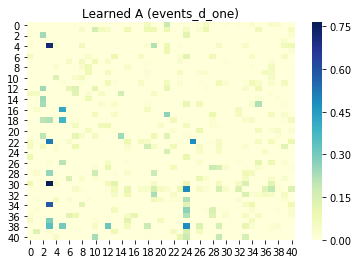

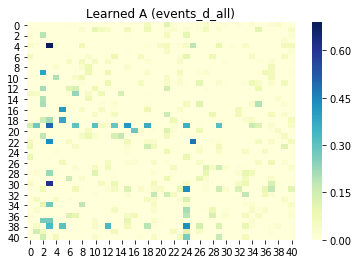

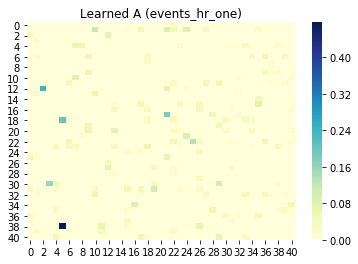

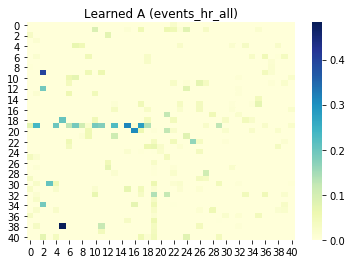

In [66]:
A_events_d_one = A_learned_list[0]
A_events_d_all = A_learned_list[1]
A_events_hr_one = A_learned_list[2]
A_events_hr_all = A_learned_list[3]

ax0 = sns.heatmap(A_events_d_one, cmap="YlGnBu")
ax0.set_title("Learned A (events_d_one)")
plt.show()

ax1 = sns.heatmap(A_events_d_all, cmap="YlGnBu")
ax1.set_title("Learned A (events_d_all)")
plt.show()

ax2 = sns.heatmap(A_events_hr_one, cmap="YlGnBu")
ax2.set_title("Learned A (events_hr_one)")
plt.show()

ax3 = sns.heatmap(A_events_hr_all, cmap="YlGnBu")
ax3.set_title("Learned A (events_hr_all)")
plt.show()

### Univariate

#### 1D scatter plots

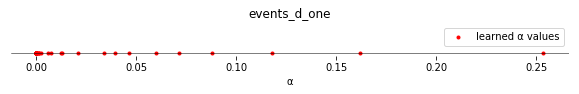

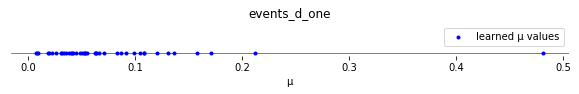

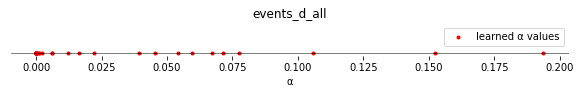

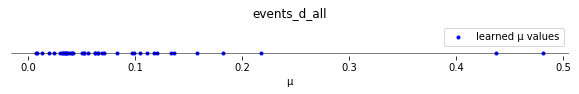

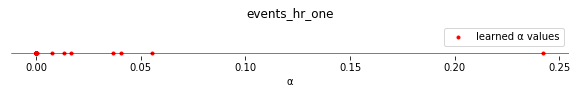

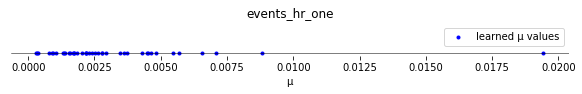

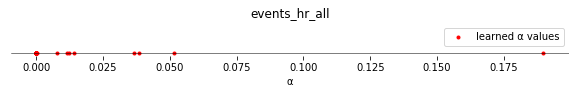

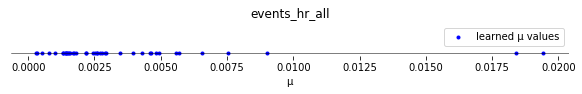

In [171]:
def generate_density_plots(df_name, alpha_i, mu_i):
    # alpha
    fig0 = plt.figure(facecolor='white')
    ax0 = plt.axes(frameon=False)
    ax0.get_xaxis().tick_bottom()   
    ax0.axes.get_yaxis().set_visible(False) 
    x = alpha_i
    y = [0.5]*len(x)
    ax0.plot(x, y, 'r.', markersize=6, label='learned α values')
    fig0.set_size_inches(10, 0.6)
    plt.xlabel("α")
    plt.legend(loc='best')
    xmin, xmax = ax0.get_xaxis().get_view_interval()
    ymin, ymax = ax0.get_yaxis().get_view_interval()
    ax0.axes.set_ylim([-1, 15])
    ax0.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=0.5))
    plt.title(df_name)
    plt.show()

    # mu
    fig0 = plt.figure(facecolor='white')
    ax0 = plt.axes(frameon=False)
    ax0.get_xaxis().tick_bottom()   
    ax0.axes.get_yaxis().set_visible(False) 
    x = mu_i
    y = [0.5]*len(x)
    ax0.plot(x, y, 'b.', markersize=6, label='learned μ values')
    fig0.set_size_inches(10, 0.6)
    plt.xlabel("μ")
    plt.legend(loc='best')
    xmin, xmax = ax0.get_xaxis().get_view_interval()
    ymin, ymax = ax0.get_yaxis().get_view_interval()
    ax0.axes.set_ylim([-1, 15])
    ax0.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=0.5))
    plt.title(df_name)
    plt.show()   
    
df_names_list = ['events_d_one', 'events_d_all', 'events_hr_one', 'events_hr_all']
for i in range(len(df_names_list)):
    generate_density_plots(df_names_list[i], alpha_learned_list_uni[i], mu_learned_list_uni[i])

#### Clustering of (α, μ) parameter values

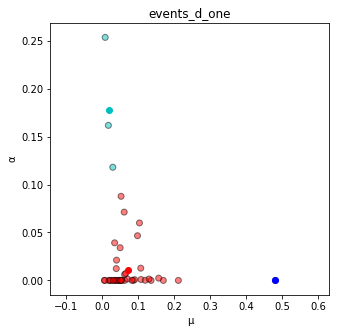

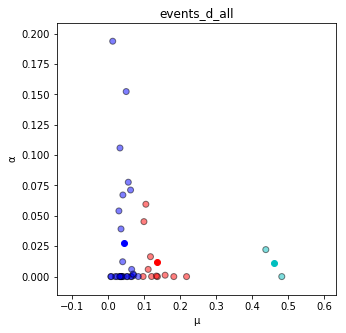

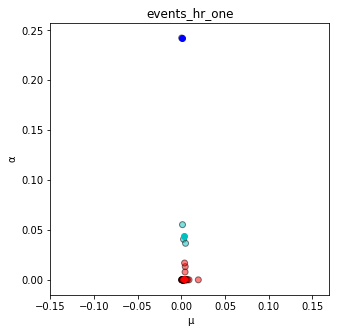

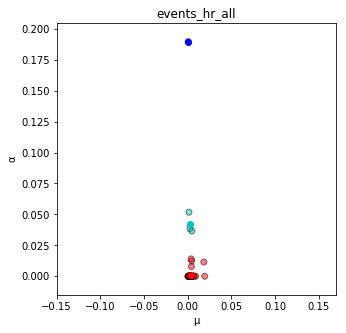

In [197]:
def generate_cluster_plots(df_name, x_list, y_list, n_clusters=3):
    df_kmeans = pd.DataFrame({'x': x_list, 'y': y_list})
    kmeans = KMeans(n_clusters)
    kmeans.fit(df_kmeans)

    labels = kmeans.predict(df_kmeans)
    centroids = kmeans.cluster_centers_
    
    fig = plt.figure(figsize=(5, 5))
    colmap = {1: 'r', 2: 'b', 3: 'c', 4: 'g', 5: 'm', 6: 'y'}
    colors = list(map(lambda x: colmap[x+1], labels))

    plt.scatter(df_kmeans['x'], df_kmeans['y'], color=colors, alpha=0.5, edgecolor='k')
    for idx, centroid in enumerate(centroids):
        plt.scatter(*centroid, color=colmap[idx+1])

    plt.xlim(min(x_list)-0.15, max(x_list)+0.15)
    plt.ylim(min(y_list)-0.015, max(y_list)+0.015)

    plt.xlabel("μ")
    plt.ylabel("α")
    plt.title(df_name)
    plt.show()
    
for i in range(len(df_names_list)):
    generate_cluster_plots(df_names_list[i], mu_learned_list_uni[i], alpha_learned_list_uni[i])